In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [25]:
#accessing list of smiles string of fda approved compounds
fda = pd.read_csv("fda.csv")
fda_smiles = fda["smiles"]


### Determing MWCO for Products:

In [ ]:
mw_ls = []
for s in fda_smiles:
    mw = Chem.rdMolDescriptors.CalcExactMolWt(Chem.MolFromSmiles(s))
    mw_ls.append(mw)
mw_values = np.array(mw_ls)

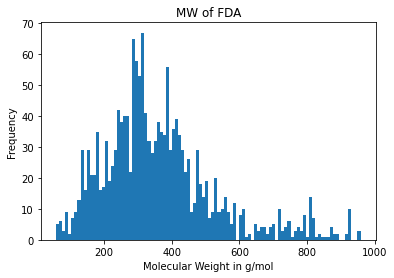

In [6]:
plt.hist(mw_values, bins = 100)
plt.xlabel("Molecular Weight in g/mol")
plt.ylabel("Frequency")
plt.title("MW of FDA")
plt.show()

In [7]:
np.mean(mw_values)

361.0275466869565

### Similiarities between Start and Target Compounds:

In [11]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

#accessing list of smiles string of both feedstock and fda approved drugs
start = pd.read_excel("Molecule Database.xlsx", sheet_name = "Start")
fda = pd.read_csv("fda.csv")

fda_smiles = fda["smiles"]
start_smiles = start["SMILES"]

#creating list of mols
fda_mol = [Chem.MolFromSmiles(f) for f in fda_smiles]
start_mol = [Chem.MolFromSmiles(s) for s in start_smiles]

#creating list of fingerprints
fda_fps = [FingerprintMols.FingerprintMol(f) for f in fda_mol]
start_fps = [FingerprintMols.FingerprintMol(s) for s in start_mol]

#intiliazes lists for dataframes
st, tg, sim = [], [], []

for i, m in enumerate(start_fps):
    #bulk comparing a start mol fp value with the entire list of fda drugs
    values = DataStructs.BulkTanimotoSimilarity(m, fda_fps)
    
    #collect the smiles and sim values
    for j, v in enumerate(values):
        sim.append(v)
        st.append(start_smiles[i])
        tg.append(fda_smiles[j])

#creating dataframe and sorting by sim values
d = {'Start':st, 'Target':tg, 'Similarity':sim}
#df_final = pd.DataFrame(data=d)
#df_final = df_final.sort_values('Similarity', ascending=False)
#df_final.to_excel('similarity.xlsx', index = False)

### Similarities between Gen 1 Expansion Prod and Targets:

In [14]:
# from rdkit import Chem
# from rdkit import DataStructs
# from rdkit.Chem.Fingerprints import FingerprintMols
# import pandas as pd

# #accessing list of smiles string of both feedstock and fda approved drugs
# prod = pd.read_excel("Start Expansion.xlsx", sheet_name = "Sheet1")
# fda = pd.read_csv("fda.csv")

# fda_smiles = fda["smiles"]
# prod_smiles = prod["Product SMILES"]

# #creating list of mols
# fda_mol = [Chem.MolFromSmiles(f) for f in fda_smiles]
# prod_mol = [Chem.MolFromSmiles(p) for p in prod_smiles]

# #creating list of fingerprints
# fda_fps = [FingerprintMols.FingerprintMol(f) for f in fda_mol]
# prod_fps = [FingerprintMols.FingerprintMol(p) for p in prod_mol]

# #intiliazes lists for dataframes
# pr, tg, sim = [], [], []

# for i, m in enumerate(prod_fps):
#     #bulk comparing a start mol fp value with the entire list of fda drugs
#     values = DataStructs.BulkTanimotoSimilarity(m, fda_fps)
    
#     #collect the smiles and sim values
#     for j, v in enumerate(values):
#         sim.append(v)
#         pr.append(prod_smiles[i])
#         tg.append(fda_smiles[j])

# #creating dataframe and sorting by sim values
# d = {'Expansion Products':pr, 'Target':tg, 'Similarity':sim}
# df_final = pd.DataFrame(data=d)
# df_final = df_final.sort_values('Similarity', ascending=False)


# df_final.to_excel('Expansion Similarities.xlsx', index = False)

KeyboardInterrupt: 

### Promising Start Compounds: Similarity T > 0.75

In [3]:
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
import pandas as pd

#accessing list of smiles string of both feedstock and fda approved drugs
start = pd.read_excel("Molecule Database.xlsx", sheet_name = "Start")
top_sim = pd.read_excel("similarity.xlsx", sheet_name = ">0.75")

prom_start = set(top_sim["Start"])
name = start["Name"]
st_smiles = start["SMILES"]
#removing duplicates
prom_start = list(set(prom_start))

#creating dictionary between start smiles and name
st = dict(zip(st_smiles, name))

## Expanding and then comparing (starting with top 15 compounds):

In [4]:
rules_df = pd.read_excel("enz_rules.xlsx", sheet_name = "Method A")
start_df = pd.read_excel("Molecule Database.xlsx", sheet_name = "Start")
cf = pd.read_excel("et_rules.xlsx", sheet_name = "co_factors")

mol_smiles = start_df["SMILES"]
#list of cof smiles per reaction
raw_cof_smiles = rules_df["SMILES"]
#lists of cof smiles
cof = cf["SMILES"]

# splits the cofactors SMILES strings into lists
cof_smiles = []
for c in raw_cof_smiles:
    cof = c.split(';')
    cof_smiles.append(cof)
    
rxn_smarts = rules_df["SMARTS"]
num_react = rules_df["Reactant Number"]

#creates a list of tuples w/ the following format:
# (smiles string of cofactors, number of reactants, smarts of reaction)
enz_rxns = list(zip(cof_smiles, num_react, rxn_smarts))

def one_step_reaction(molecule_smiles, enzyme_reaction_tuples, cutoff):
    """
    parameters:
    molecule_smiles: list of string
        SMILES strings of the starting molecules
    enzyme_reaction_tuples: list of tuples
        tuples contain the following information for each reaction: 
        (SMILES string of necessary cofactors, # of reactants, SMARTS patterns for the reaction)
    cutoff: molecular weight cutoff in g/mol
    
    return:
    nodes: set of string
    SMILES of all of the new products and initial molecules
    edges: set of tuples
    (SMILES of reactants, SMILES of products, SMARTS of rxn)
    """
    nodes = set()
    edges = set()
    #run expansion loop
    
    for mol in molecule_smiles:
        for rxn_tup in (enzyme_reaction_tuples):
            #initiliazes rxn object
            rxn = AllChem.ReactionFromSmarts(rxn_tup[2])
            #get number of reactants necessary
            rct_num = rxn_tup[1]
            #initializing reactants list
            rct = []
            if rxn_tup[0] != 'none':
                #adds cofactors when necessary
                rct = rxn_tup[0].copy()
            for i in range(rct_num):
                #adds starting molecule
                rct.append(mol)
            #removing any empty cells
            rct_list = [r for r in rct if r != "none"]
            
            
            reactants = [Chem.MolFromSmiles(r) for r in rct_list]
            for outcome in rxn.RunReactants(reactants):
                #can not test for mol validity at this point!!!
                for prod_mol in outcome:
                    #unmap atom
                    for atom in prod_mol.GetAtoms():
                        atom.SetAtomMapNum(0)
                    prod_smiles = Chem.MolToSmiles(prod_mol)
                    prod = prod_smiles.split(".")
                    for p in prod:
                        if p not in cof:
                            p_mol = Chem.MolFromSmiles(p)
                            #checking for valid mol and MWC
                            if p_mol is not None and Chem.rdMolDescriptors.CalcExactMolWt(p_mol) < cutoff:
                                nodes.add(p)
                                edges.add((mol, p, rxn_tup[2]))

    #include starting materials in products
    return nodes.union(molecule_smiles), edges

prod, rxn = one_step_reaction(prom_start, enz_rxns, 1000)

plicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 14 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 16 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 10 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 3 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 12 O, 3, is greater than permitted
RDKit ERROR: [14:19:26] Explicit valence for atom # 14 O, 3, is greater

## Comparing Subset of Products with Target Compounds:

In [8]:
fda = pd.read_csv("fda.csv")
fda_smiles = fda["smiles"]
prod_smiles = list(prod)

#creating list of mols
fda_mol = [Chem.MolFromSmiles(f) for f in fda_smiles]
prod_mol = [Chem.MolFromSmiles(p) for p in prod]

#creating list of fingerprints
fda_fps = [FingerprintMols.FingerprintMol(f) for f in fda_mol]
prod_fps = [FingerprintMols.FingerprintMol(p) for p in prod_mol]

#intiliazes lists for dataframes
pr, tg, sim = [], [], []

for i, m in enumerate(prod_fps):
    #bulk comparing a start mol fp value with the entire list of fda drugs
    values = DataStructs.BulkTanimotoSimilarity(m, fda_fps)
    
    #collect the smiles and sim values
    for j, v in enumerate(values):
        if v > 0.85:
            sim.append(v)
            pr.append(prod_smiles[i])
            tg.append(fda_smiles[j])

In [10]:
#creating dataframe and sorting by sim values
df = pd.DataFrame({'Product':pr, 'Target': tg, 'Similarity':sim})
df = df.sort_values('Similarity', ascending=False)


df.to_csv('prod_similarity.csv', index = False)